This is a simulation of running a Q-learning algorithm on an SIR model in an attempt to control the number of infections so it remains under a certain threshold or remain within a certain bracket. Each simulation number corresponds to the experiment number menioned in the dissertation. To run the testing on one of the uploaded Q-tables, only run the first section and then check the comments in the "Loading and running provided data/Q-tables"

# Needed functions and elements for the simulations


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy.signal import savgol_filter

Defining the required functions

In [ ]:
# Takes in a state as a parameter and returns the index of the closest state from the set of possible states (nearest neighbour)
def get_state_index(state):
  try:
    # Calculates all distances between the chosen state and every possible states
    distances = np.linalg.norm(np.array(all_states) - np.array(state), axis=1)
    # Finding the index of the closest state using the closest distance
    closest_index = np.argmin(distances)
    return closest_index
  except ValueError:
    print('Value of state not found in the list')

# Takes in a state as a parameter and returns the closest state in the set of possible states for our environment
def get_closest_state(state):
  closest_index = get_state_index(state)
  closest_state = all_states[closest_index]
  return closest_state

# Takes in a value beta as a parameter and returns the closest action value from the set of possible actions
def get_beta(beta):
  try:
    nearest_beta = actions[get_beta_index(beta)]
    return nearest_beta
  except ValueError:
    print('Value of beta not found in the list')

# Takes in a value beta as a parameter and returns the index of the closest action value from the set of possible actions
def get_beta_index(beta):
  # Computing the difference between beta and all values in the actions array and getting the index of the smallest difference
  converted_actions = np.array(actions)
  beta_index = np.abs(converted_actions - beta).argmin()
  return beta_index

# Takes a state and an action and computes the next state by using the SIR equations
def take_action(cur_state, beta):
  # Extracting the current values of S, I, and R from the current state
  cur_S = cur_state[0]
  cur_I = cur_state[1]
  cur_R = cur_state[2]
  # Computing the next values for S, I and R using the SIR model differential equations
  next_dsdt_p = - beta * cur_S * cur_I
  next_didt = beta * cur_S * cur_I - gamma * cur_I
  next_drdt = gamma * cur_I
  next_s_p = cur_S + next_dsdt_p
  next_i = cur_I + next_didt
  next_r = cur_R + next_drdt
  next_state_tuple = (next_s_p, next_i, next_r)
  next_s = get_closest_state(next_state_tuple)
  return next_s

# Reward function 1
# Function for calculating the reward for a state, the agent recieves
# positive or negative reinforcement based on whether the value
# is below or above Itarget
def calculate_reward(next_s):
  if next_s[1] <= Itarget:  # good outcome, cases under control
    reward = abs(next_s[1] - Itarget)*10
    return reward #, False
  else:  # bad outcome, cases above what we want
    reward = (-abs(Itarget - next_s[1]))
    return reward #, True

# Reward function 2
# Function for calculating the reward for a state, the agent recieves
# positive or negative reinforcement based on whether the infections
# are within the bracket size we specified
def calculate_reward2(next_s):
  if abs(next_s[1] - Itarget) <= allowance_bracket:  # good outcome, cases under control
    reward = abs(next_s[1] - Itarget)*100
    return reward
  elif (next_s[1] <= (Itarget - allowance_bracket)):  # avergae outcome, cases not within the interval we want but under it
    reward = (abs(Itarget - next_s[1])) *10
    return reward
  else:
    reward = (-abs(Itarget - next_s[1]))*5 # worst outcome, cases are out of control
    return reward

Function defining the Q-learning algorithm we are using

In [ ]:
def rl_train(r_func, q_tabl, episodes, iterations, chooseRanState, rl_gam, rl_epsi, rl_alph, decay_multi):

  # The initial fixed state if needed
  init_s = 0.995
  init_i = 0.005
  init_r = 0
  init = (init_s, init_i, init_r)  # S, I, R

  # Start of an episode
  for e in range(episodes):
    print(e)
    done = False

    # Decaying policy for the exploration rate
    if (rl_epsi > 0.1):
        rl_epsi *= decay_multi

    # if statement for either starting every episode at a random state or the fixed initial state
    if (chooseRanState):
      random_index = np.random.randint(0, all_states.shape[0])
      cur_state = all_states[random_index]
    else:
      cur_state = get_closest_state(init)

    # Start of an iteration
    for i in range(max_iter):
      # The epsilone greedy policy for choosing a value for beta
      if np.random.rand() < rl_epsi:
          beta = np.random.choice(actions)
      else:
          beta = actions[np.argmax(q_tabl[get_state_index(cur_state)])]


      next_s = take_action(cur_state, beta)
      reward = r_func(next_s)

      # Updating the Q_table for the current state-action pair using Bellman equation
      q_tabl[get_state_index(cur_state)][get_beta_index(beta)] += rl_alph * (reward + rl_gam * np.max(q_tabl[get_state_index(next_s)]) - q_tabl[get_state_index(cur_state)][ get_beta_index(beta)])

      # Updating the state of the system
      cur_state = next_s

  return q_tabl

Function for testing the trained agent

In [ ]:
def test_q_learning(q_tabl, time_period):

  # setting up the system's initial state
  init_s = 0.995
  init_i = 0.005
  init_r = 0
  init = (init_s, init_i, init_r)  # S, I, R
  cur_state = get_closest_state(init)

  # elements needed for the training
  num_days = time_period
  s_values = np.zeros(num_days)
  i_values = np.zeros(num_days)
  r_values = np.zeros(num_days)
  beta_vals = np.zeros(num_days)
  reward_val = 0
  cumulative_qval = 0
  days_within_target = 0

  for t in range(num_days):
      # Save values to plot them
      s_values[t] = cur_state[0]
      i_values[t] = cur_state[1]
      r_values[t] = cur_state[2]

      # Getting the actions probabilities
      cur_state_index = get_state_index(cur_state)
      action_qvals = q_tabl[cur_state_index]

      # Calculating probabilities out of the qvalues for each action
      shifted_vals = action_qvals - np.min(action_qvals) + 1
      sum_shifted_arr = np.sum(shifted_vals)
      probabilities = shifted_vals / sum_shifted_arr

      # softening the probabilities for a more deterministic action choice
      temperature = 0.3
      softened_probas = probabilities ** (1 / temperature)
      softened_probas /= np.sum(softened_probas)

      # Picking a value beta based on the calculated probabilities
      beta = np.random.choice(actions, p=softened_probas)
      beta_vals[t] = beta

      # Updating the system's state
      next_s = take_action(cur_state, beta)
      cur_state = next_s

      cumulative_qval += q_tabl[get_state_index(cur_state)][get_beta_index(beta)]


      reward_val += calculate_reward(cur_state)

      if (cur_state[1] <= Itarget):
          days_within_target += 1

  return s_values, i_values, r_values, beta_vals, cumulative_qval, reward_val, days_within_target

Function for testing one run and plotting it

In [ ]:
def plot_one_test(q_tabl, time_period):
  svals, ivals, rvals, betavals, cumulative_qvals, reward_vals, days_within_targ = test_q_learning(q_tabl, Itarget, time_period)

  # Applying the Savitzky-Golay filter to beta values so it stabilises them
  window_length = 10
  polyorder = 1
  smoothed_betas = savgol_filter(betavals, window_length, polyorder)

  print("This is the sum of rewards: ", reward_vals)
  print("This is the cumulative sum of of Q-values: ", cumulative_qvals)

  t_values = np.arange(num_days)
  plt.plot(t_values, svals, label='S')
  plt.plot(t_values, ivals, label='I')
  plt.plot(t_values, rvals, label='R')
  plt.legend()
  plt.xlabel('Time')
  plt.ylabel('Proportion of Population')
  plt.show()
  plt.plot(t_values, betavals, label='betas')
  plt.legend()
  plt.xlabel('Time')
  plt.ylabel('beta value')
  plt.show()

Function for testing the model over a number of iterations to get the average performance

In [ ]:
def produce_avg_graph(num_iter, time_period, q_tabl):

  num_days = time_period
  average_s_vals = np.zeros(num_days)
  average_i_vals = np.zeros(num_days)
  average_r_vals = np.zeros(num_days)
  average_beta_vals = np.zeros(num_days)
  average_cumulative_qvals = 0
  average_reward_vals = 0
  avg_days_within_targ = 0
  avg_std_dev = 0 # average standard deviation

  sum_s_vals = np.zeros(num_days)
  sum_i_vals = np.zeros(num_days)
  sum_r_vals = np.zeros(num_days)
  sum_beta_vals = np.zeros(num_days)
  sum_cumulative_qvals = 0
  sum_reward_vals = 0
  sum_days_within_targ = 0
  sum_std_dev = 0

  # Running the simulation num_iter times
  for i in range(num_iter):
      s_vals = np.zeros(num_days)
      i_vals = np.zeros(num_days)
      r_vals = np.zeros(num_days)
      beta_values = np.zeros(num_days)


      # Run testing
      s_vals, i_vals, r_vals, beta_values, cumulative_qvals, reward_vals, days_within_targ = test_q_learning(q_tabl, num_days)


      # Add the results to the sum of all simulations
      sum_s_vals += s_vals
      sum_i_vals += i_vals
      sum_r_vals += r_vals
      sum_beta_vals += beta_values
      sum_cumulative_qvals += cumulative_qvals
      sum_reward_vals += reward_vals
      sum_days_within_targ += days_within_targ
      sum_std_dev += np.std(i_vals)

  # Divide the sums by the number of iterations to get the averages
  average_s_vals = sum_s_vals/num_iter
  average_i_vals = sum_i_vals/num_iter
  average_r_vals = sum_r_vals/num_iter
  average_beta_vals = sum_beta_vals/num_iter
  average_cumulative_qvals = sum_cumulative_qvals/num_iter
  average_reward_vals = sum_reward_vals/num_iter
  avg_days_within_targ = sum_days_within_targ/num_iter
  avg_std_dev = sum_std_dev/num_iter

  print("This is the average sum of rewards: ", average_reward_vals)
  print("This is the average sum of Q-values: ", average_cumulative_qvals)
  print("This is the average of the days I stayed within target: ", avg_days_within_targ)
  print("This is the average standard deviation: ", avg_std_dev)

  # Plot the graph for SIR
  t_values = np.arange(num_days)
  plt.plot(t_values, average_s_vals, label='S')
  plt.plot(t_values, average_i_vals, label='I')
  plt.plot(t_values, average_r_vals, label='R')
  plt.axhline(y=0.1, color='r', linestyle='--', label='Itarget')
  plt.legend()
  plt.xlabel('Time')
  plt.ylabel('Average Proportion of Population')
  plt.show()

  # Applying the Savitzky-Golay filter to beta values so it stabilises them
  window_length = 10
  polyorder = 1
  smoothed_betas = savgol_filter(average_beta_vals, window_length, polyorder)

  # Plotting the average chosen beta values throughout the experiment
  plt.plot(t_values, average_beta_vals, label='betas')
  plt.plot(t_values, smoothed_betas, label='smoothed betas')
  plt.legend()
  plt.xlabel('Time')
  plt.ylabel('Average beta')
  plt.show()

  return average_i_vals

Setting up the environement

In [ ]:
Itarget = 0.1  # the number of infection we want to stay below
allowance_bracket = 0.01 # the size of interval we want our infections to stay within

tr = 5  # time it takes to recover in days
gamma = 1 / tr  # recovery rate (stays constant)


# Define all possible states and actions
actions = np.arange(0.2, 1, 0.05)
setOfStates_s = np.arange(0, 1.005, 0.005)
setOfStates_i = np.arange(0, 1.005, 0.005)
setOfStates_r = np.arange(0, 1.005, 0.005)
all_states = np.array(
    [(s, i, r) for s in setOfStates_s for i in setOfStates_i for r in setOfStates_r if s + i + r == 1])

# Initilizing the Q-table
num_states = len(all_states)
num_actions = len(actions)
q_table = np.ones((num_states, num_actions))

# Loading and running the provided data/Q-tables

To use the Q-table submitted along this file, uncomment the corresponding line and run this last section only

In [ ]:
# q_table_loaded = np.load('/content/experiment1a.npy')
# q_table_loaded = np.load('/content/experiment1b.npy')
# q_table_loaded = np.load('/content/experiment2a.npy')
# q_table_loaded = np.load('/content/experiment2b.npy')
# q_table_loaded = np.load('/content/experiment3a.npy')
# q_table_loaded = np.load('/content/experiment3b.npy')
# q_table_loaded = np.load('/content/experiment4a.npy')
# q_table_loaded = np.load('/content/experiment4b.npy')

This is the average sum of rewards:  64.54709999999999
This is the average sum of Q-values:  536.9975528376269
This is the average of the days I stayed within target:  89.86
This is the average standard deviation:  0.056061080322987795


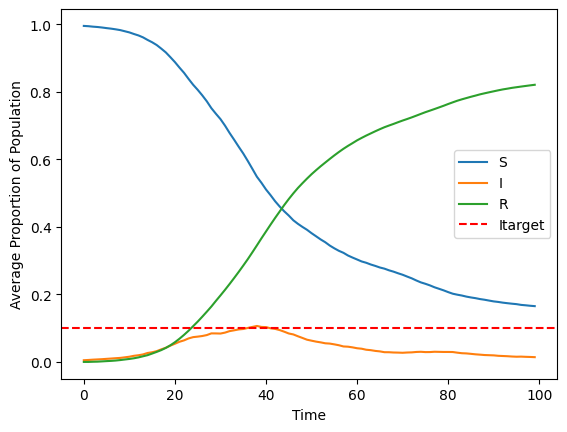

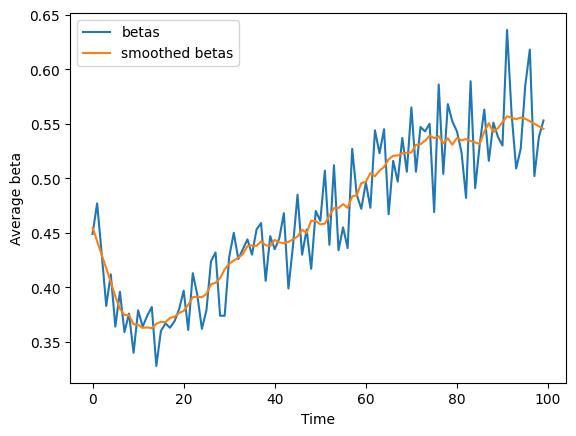

In [ ]:
num_test_iter = 50
num_time_steps = 100
avg_infec_loaded = produce_avg_graph(num_test_iter, num_time_steps, q_table_loaded)

# Simulation 1a: We always start as the system's initial state at every episode and we use reward function 1 & Exploitaion > Exploration

Step 1: Training the model

In [ ]:
# Experiment specifications
num_episodes = 2000 # Number of episodes to run
max_iter =  110# Number of iteration in every episode
chooseRanState = False # RL agent will start every episode at the initial state

# Bellman's equation params
rl_alph = 0.3  # learning rate alpha
rl_gam = 0.9  # discount factor gamma
rl_epsi = 0.99  # exploration rate epsilon
decay_mult = 0.99 # decaying rate

q_table1a = q_table

q_table1a = rl_train(calculate_reward, q_table1a, num_episodes, max_iter, chooseRanState, rl_gam, rl_epsi, rl_alph, decay_mult)

Step 2: Testing the model over a number of iterations to get the average performance

This is the average sum of rewards:  63.962299999999956
This is the average sum of Q-values:  521.7004855383462
This is the average of the days I stayed within target:  89.32
This is the average standard deviation:  0.05532553022073165


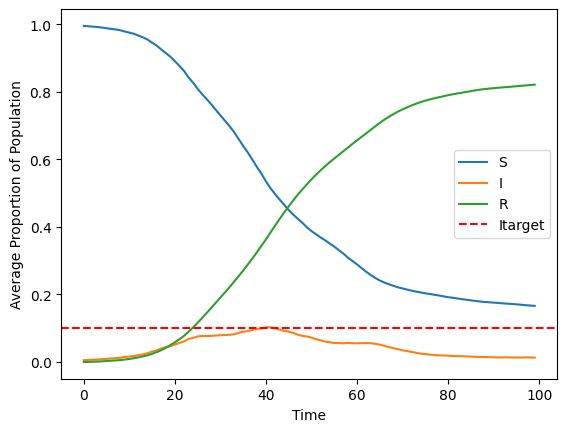

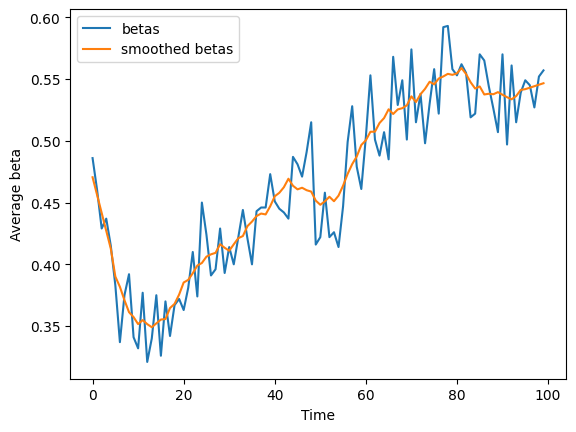

In [ ]:
num_test_iter = 50
num_time_steps = 100
avg_infec1 = produce_avg_graph(num_test_iter, num_time_steps, q_table1a)

In [ ]:
# Show Q-table
plt.imshow(q_table1a, cmap='hot', aspect=0.005)
plt.colorbar()
plt.show()

# Simulation 1b: We always start as the system's initial state at every episode and we use reward function 1 & Exploitaion < Exploration

Step 1: Training the model

In [ ]:
# Experiment specifications
num_episodes = 8000 # Number of episodes to run
max_iter =  60# Number of iteration in every episode
chooseRanState = False # RL agent will start every episode at the initial state

# Bellman's equation params
rl_alph = 0.3  # learning rate alpha
rl_gam = 0.9  # discount factor gamma
rl_epsi = 0.99  # exploration rate epsilon
decay_mult = 0.9999 # decaying rate

q_table1b = q_table

q_table1b = rl_train(calculate_reward, q_table1b, num_episodes, max_iter, chooseRanState, rl_gam, rl_epsi, rl_alph, decay_mult)

Step 2: Testing the model over a number of iterations to get the average performance

This is the average sum of rewards:  63.62989999999998
This is the average sum of Q-values:  613.0237929847953
This is the average of the days I stayed within target:  88.54
This is the average standard deviation:  0.055199711730713225


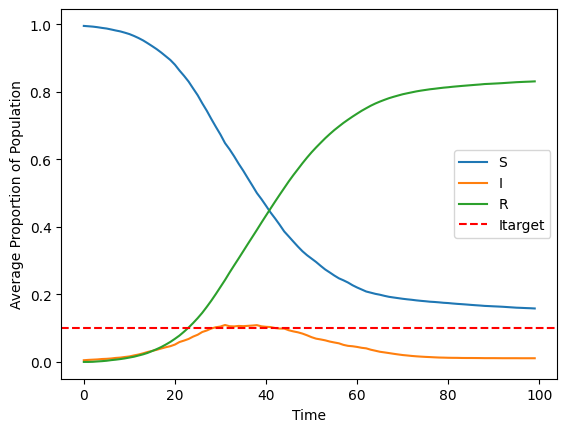

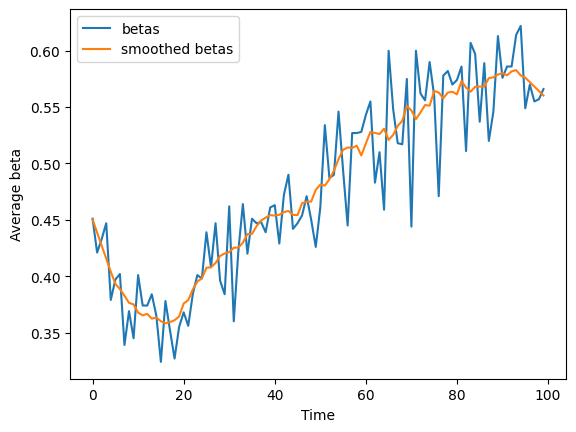

In [ ]:
num_test_iter = 50
num_time_steps = 100
avg_infec1 = produce_avg_graph(num_test_iter, num_time_steps, q_table1b)

In [ ]:
# Show Q-table
plt.imshow(q_table1b, cmap='hot', aspect=0.005)
plt.colorbar()
plt.show()

# Simulation 2a: We always start as the system's initial state at every episode and we use reward function 2 & Exploitation > Exploration

Step 1: Training the model

In [ ]:
# Experiment specifications
num_episodes = 2000 # Number of episodes to run
max_iter = 110 # Number of iteration in every episode
chooseRanState = False # RL agent will start every episode at the initial state

# Bellman's equation params
rl_alph = 0.3  # learning rate alpha
rl_gam = 0.9  # discount factor gamma
rl_epsi = 0.99  # exploration rate epsilon
decay_mult = 0.99 # decaying rate

q_table2a = q_table
q_table2a = rl_train(calculate_reward2, q_table2a, num_episodes, max_iter, chooseRanState, rl_gam, rl_epsi, rl_alph, decay_mult)

Step 2: Testing the model over a number of iterations to get the average performance

This is the average sum of rewards:  62.02659999999996
This is the average sum of Q-values:  472.25834796206686
This is the average of the days I stayed within target:  82.62
This is the average standard deviation:  0.058725268940267694


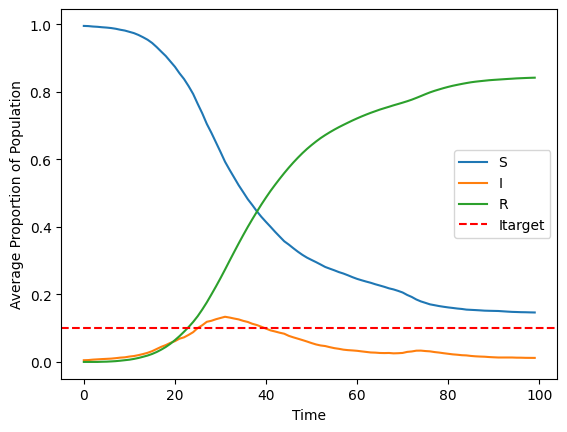

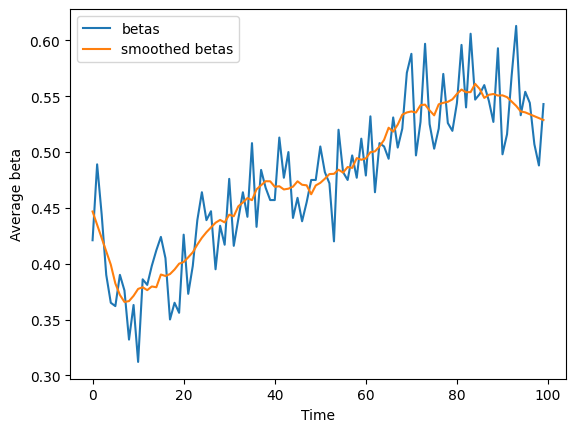

In [ ]:
num_test_iter = 50
num_time_steps = 100
avg_infec2 = produce_avg_graph(num_test_iter, num_time_steps, q_table2a)

In [ ]:
# Show Q-table
plt.imshow(q_table2a, cmap='hot', aspect=0.005)
plt.colorbar()
plt.show()

# Simulation 2b: We always start as the system's initial state at every episode and we use reward function 2 & Exploitation < Exploration

Step 1: Training the model

In [ ]:
# Experiment specifications
num_episodes = 8000 # Number of episodes to run
max_iter = 60 # Number of iteration in every episode
chooseRanState = False # RL agent will start every episode at the initial state

# Bellman's equation params
rl_alph = 0.3  # learning rate alpha
rl_gam = 0.9  # discount factor gamma
rl_epsi = 0.99  # exploration rate epsilon
decay_mult = 0.9999 # decaying rate

q_table2b = q_table
q_table2b = rl_train(calculate_reward2, q_table2b, num_episodes, max_iter, chooseRanState, rl_gam, rl_epsi, rl_alph, decay_mult)

Step 2: Testing the model over a number of iterations to get the average performance

This is the average sum of rewards:  62.36739999999995
This is the average sum of Q-values:  683.353911125283
This is the average of the days I stayed within target:  78.28
This is the average standard deviation:  0.06885573217954817


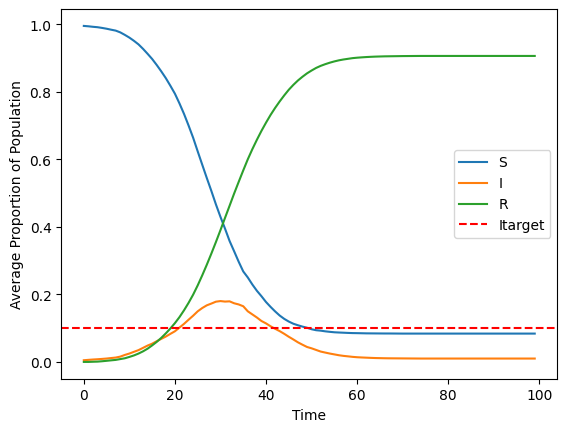

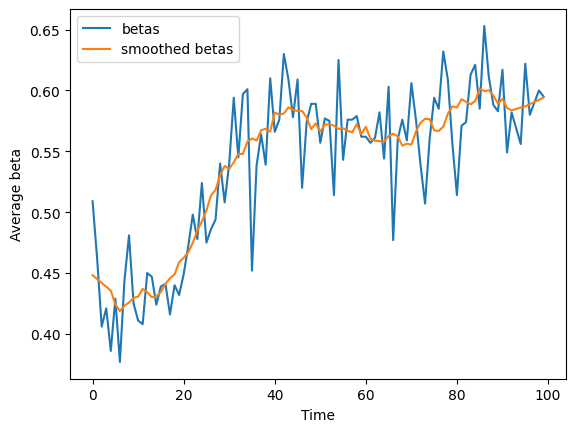

In [ ]:
num_test_iter = 50
num_time_steps = 100
avg_infec2 = produce_avg_graph(num_test_iter, num_time_steps, q_table2b)

In [ ]:
# Show Q-table
plt.imshow(q_table2b, cmap='hot', aspect=0.005)
plt.colorbar()
plt.show()

# Simulation 3a: We start each episode at a random initial state and we use reward function 1 & Exploitation > Exploration

Step 1: Training the model

In [ ]:
# Experiment specifications
num_episodes = 2000 # Number of episodes to run
max_iter = 110 # Number of iteration in every episode
chooseRanState = True # RL agent will start every episode at the initial state

# Bellman's equation params
rl_alph = 0.3  # learning rate alpha
rl_gam = 0.9  # discount factor gamma
rl_epsi = 0.99  # exploration rate epsilon
decay_mult = 0.99

q_table3a = q_table

q_table3a = rl_train(calculate_reward, q_table3a, num_episodes, max_iter, chooseRanState, rl_gam, rl_epsi, rl_alph, decay_mult)

Step 2: Testing the model over a number of iterations to get the average performance

This is the average sum of rewards:  61.92639999999995
This is the average sum of Q-values:  584.1151199768188
This is the average of the days I stayed within target:  82.2
This is the average standard deviation:  0.05983633498322948


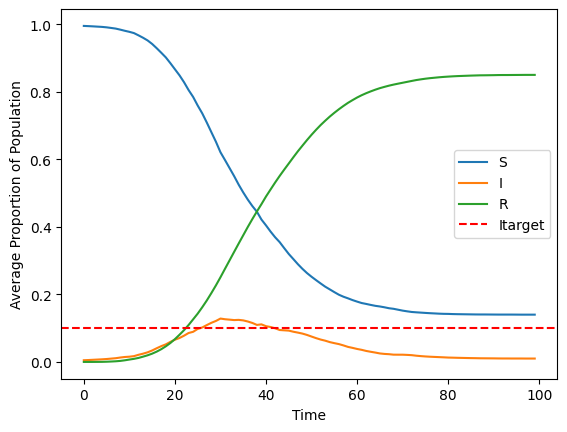

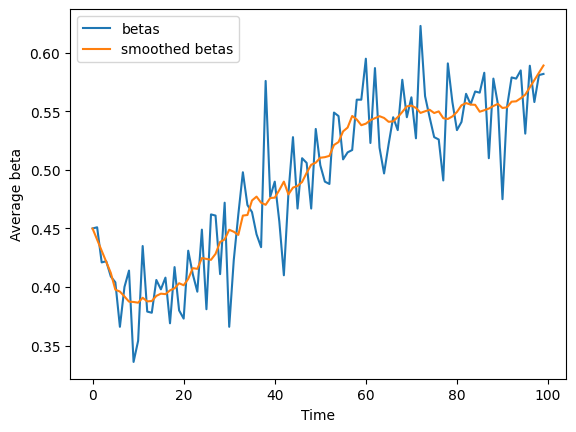

In [ ]:
num_test_iter = 50
num_days = 100
avg_infec3 = produce_avg_graph(num_test_iter, num_days, q_table3a)

In [ ]:
# Show Q-table
plt.imshow(q_table3a, cmap='hot', aspect=0.005)
plt.colorbar()
plt.show()

# Simulation 3b: We start each episode at a random initial state and we use reward function 1 & Exploitaion < Exploration

Step 1: Training the model

In [ ]:
# Experiment specifications
num_episodes = 8000 # Number of episodes to run
max_iter = 60 # Number of iteration in every episode
chooseRanState = True # RL agent will start every episode at the initial state

# Bellman's equation params
rl_alph = 0.3  # learning rate alpha
rl_gam = 0.9  # discount factor gamma
rl_epsi = 0.99  # exploration rate epsilon
decay_mult = 0.9999

q_table3b = q_table

q_table3b = rl_train(calculate_reward, q_table3b, num_episodes, max_iter, chooseRanState, rl_gam, rl_epsi, rl_alph, decay_mult)

Step 2: Testing the model over a number of iterations to get the average performance

This is the average sum of rewards:  62.07869999999994
This is the average sum of Q-values:  622.1711855273618
This is the average of the days I stayed within target:  82.68
This is the average standard deviation:  0.059730884052385844


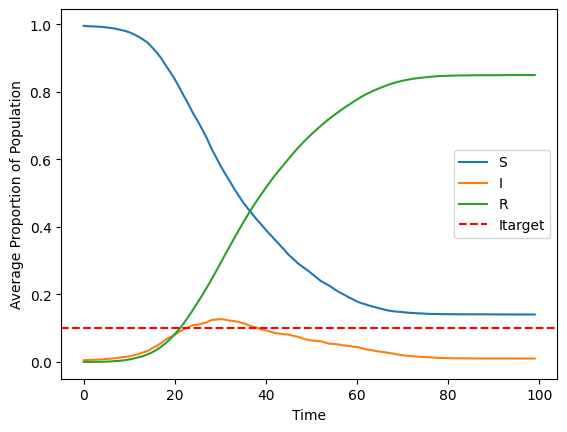

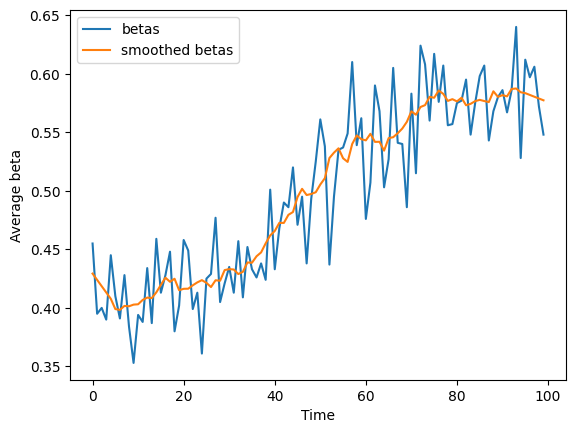

In [ ]:
num_test_iter = 50
num_days = 100
avg_infec3 = produce_avg_graph(num_test_iter, num_days, q_table3b)

In [ ]:
# Show Q-table
plt.imshow(q_table3b, cmap='hot', aspect=0.005)
plt.colorbar()
plt.show()

# Simulation 4a: We start each episode at a random initial state and we use reward function 2 & Exploitaion > Exploration

Step 1: Training the model

In [ ]:
# Experiment specifications
num_episodes = 2000 # Number of episodes to run
max_iter = 120 # Number of iteration in every episode
chooseRanState = True # RL agent will start every episode at the initial state

# Bellman's equation params
rl_alph = 0.3  # learning rate alpha
rl_gam = 0.9  # discount factor gamma
rl_epsi = 0.99  # exploration rate epsilon
decay_mult = 0.99

q_table4a = q_table

q_table4a = rl_train(calculate_reward2, q_table4a, num_episodes, max_iter, chooseRanState, rl_gam, rl_epsi, rl_alph, decay_mult)

Step 2: Testing the model over a number of iterations to get the average performance

This is the average sum of rewards:  65.82269999999995
This is the average sum of Q-values:  592.1763684012844
This is the average of the days I stayed within target:  82.34
This is the average standard deviation:  0.08204345024244247


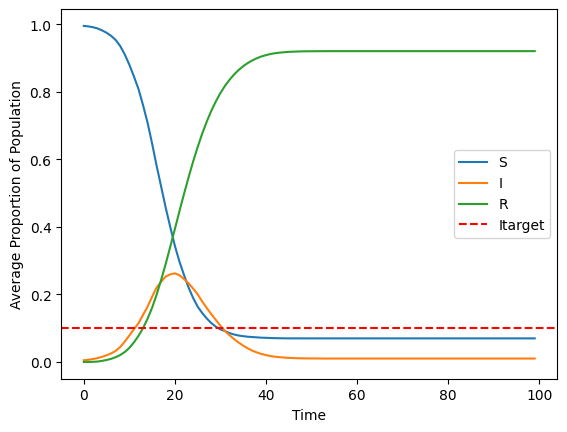

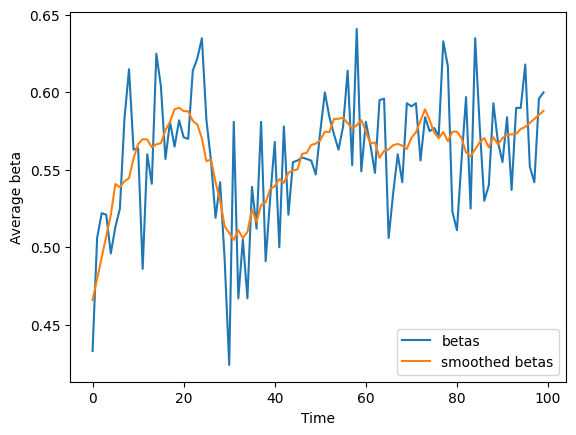

In [ ]:
num_test_iter = 50
num_time_steps = 100
avg_infec4 = produce_avg_graph(num_test_iter, num_time_steps, q_table4a)

In [ ]:
# Show Q-table
plt.imshow(q_table4a, cmap='hot', aspect=0.005)
plt.colorbar()
plt.show()

# Simulation 4b: We start each episode at a random initial state and we use reward function 2 & Exploitaion > Exploration

Step 1: Training the model

In [ ]:
# Experiment specifications
num_episodes = 8000 # Number of episodes to run
max_iter = 60 # Number of iteration in every episode
chooseRanState = True # RL agent will start every episode at the initial state

# Bellman's equation params
rl_alph = 0.3  # learning rate alpha
rl_gam = 0.9  # discount factor gamma
rl_epsi = 0.99  # exploration rate epsilon
decay_mult = 0.9999

q_table4b = q_table

q_table4b = rl_train(calculate_reward2, q_table4b, num_episodes, max_iter, chooseRanState, rl_gam, rl_epsi, rl_alph, decay_mult)

Step 2: Testing the model over a number of iterations to get the average performance

This is the average sum of rewards:  66.20379999999996
This is the average sum of Q-values:  657.4011234299458
This is the average of the days I stayed within target:  82.86
This is the average standard deviation:  0.08385643456510122


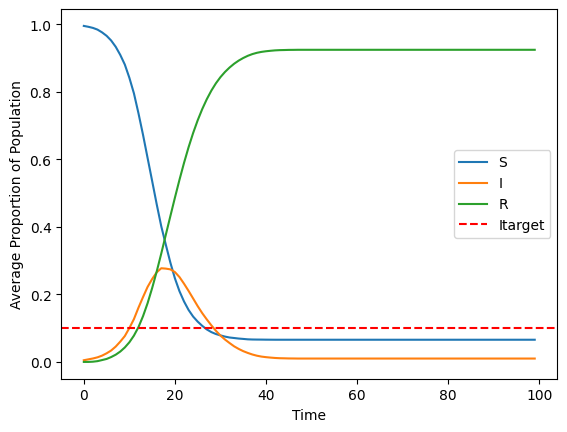

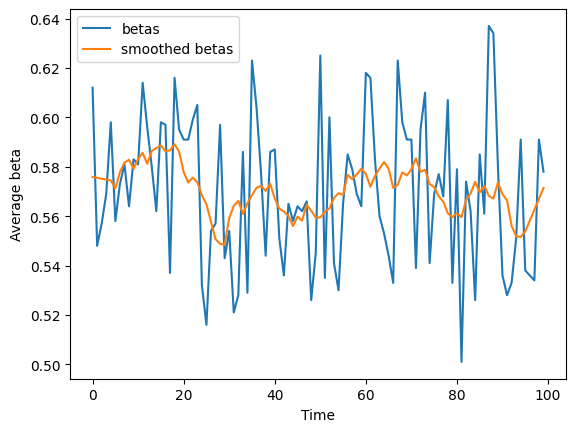

In [ ]:
num_test_iter = 50
num_time_steps = 100
avg_infec4 = produce_avg_graph(num_test_iter, num_time_steps, q_table4b)

In [ ]:
# Show Q-table
plt.imshow(q_table4b, cmap='hot', aspect=0.005)
plt.colorbar()
plt.show()

# Simulation without any machine learning, choosing purely random actions

In [ ]:
def test_q_learning2(time_period):

  # setting up the system's initial state
  init_s = 0.995
  init_i = 0.005
  init_r = 0
  init = (init_s, init_i, init_r)  # S, I, R
  cur_state = get_closest_state(init)

  # elements needed for the training
  num_days = time_period
  s_values = np.zeros(num_days)
  i_values = np.zeros(num_days)
  r_values = np.zeros(num_days)
  beta_vals = np.zeros(num_days)
  reward_val = 0
  days_within_target = 0
  cumulative_qval = 0

  for t in range(num_days):
      # Save values to plot them
      s_values[t] = cur_state[0]
      i_values[t] = cur_state[1]
      r_values[t] = cur_state[2]

      # Getting the actions probabilities
      cur_state_index = get_state_index(cur_state)

      # Picking a value beta based on the calculated probabilities
      beta = np.random.choice(actions)
      beta_vals[t] = beta

      # Updating the system's state
      next_s = take_action(cur_state, beta)
      cur_state = next_s

      if (cur_state[1] <= Itarget):
          days_within_target += 1

      reward_val += calculate_reward(cur_state)

  return s_values, i_values, r_values, beta_vals, cumulative_qval, reward_val, days_within_target

In [ ]:
def produce_avg_graph2(num_iter, time_period):

  num_days = time_period
  average_s_vals = np.zeros(num_days)
  average_i_vals = np.zeros(num_days)
  average_r_vals = np.zeros(num_days)
  average_beta_vals = np.zeros(num_days)
  average_cumulative_qvals = 0
  average_reward_vals = 0
  avg_days_within_targ = 0

  sum_s_vals = np.zeros(num_days)
  sum_i_vals = np.zeros(num_days)
  sum_r_vals = np.zeros(num_days)
  sum_beta_vals = np.zeros(num_days)
  sum_cumulative_qvals = 0
  sum_reward_vals = 0
  sum_days_within_targ = 0

  # Running the simulation num_iter times
  for i in range(num_iter):
      s_vals = np.zeros(num_days)
      i_vals = np.zeros(num_days)
      r_vals = np.zeros(num_days)
      beta_values = np.zeros(num_days)


      # Run testing
      s_vals, i_vals, r_vals, beta_values, cumulative_qvals, reward_vals, days_within_targ = test_q_learning2(num_days)


      # Add the results to the sum of all simulations
      sum_s_vals += s_vals
      sum_i_vals += i_vals
      sum_r_vals += r_vals
      sum_beta_vals += beta_values
      sum_cumulative_qvals += cumulative_qvals
      sum_reward_vals += reward_vals
      sum_days_within_targ += days_within_targ
  # Divide the sums by the number of iterations to get the averages
  average_s_vals = sum_s_vals/num_iter
  average_i_vals = sum_i_vals/num_iter
  average_r_vals = sum_r_vals/num_iter
  average_beta_vals = sum_beta_vals/num_iter
  average_cumulative_qvals = sum_cumulative_qvals/num_iter
  average_reward_vals = sum_reward_vals/num_iter
  avg_days_within_targ = sum_days_within_targ/num_iter

  print("This is the average sum of rewards: ", average_reward_vals)
  print("This is the average sum of Q-values: ", average_cumulative_qvals)
  print("This is the average of the days I stayed within target: ", avg_days_within_targ)

  # Plot the graph for SIR
  t_values = np.arange(num_days)
  plt.plot(t_values, average_s_vals, label='S')
  plt.plot(t_values, average_i_vals, label='I')
  plt.plot(t_values, average_r_vals, label='R')
  plt.axhline(y=0.1, color='r', linestyle='--', label='Itarget')
  plt.legend()
  plt.xlabel('Time')
  plt.ylabel('Average Proportion of Population')
  plt.show()

  # Applying the Savitzky-Golay filter to beta values so it stabilises them
  window_length = 10
  polyorder = 1
  smoothed_betas = savgol_filter(average_beta_vals, window_length, polyorder)

  # Plotting the average chosen beta values throughout the experiment
  plt.plot(t_values, average_beta_vals, label='betas')
  plt.plot(t_values, smoothed_betas, label='smoothed betas')
  plt.legend()
  plt.xlabel('Time')
  plt.ylabel('Average beta')
  plt.show()


  return average_i_vals

This is the average sum of rewards:  65.98249999999993
This is the average sum of Q-values:  0.0
This is the average of the days I stayed within target:  82.64


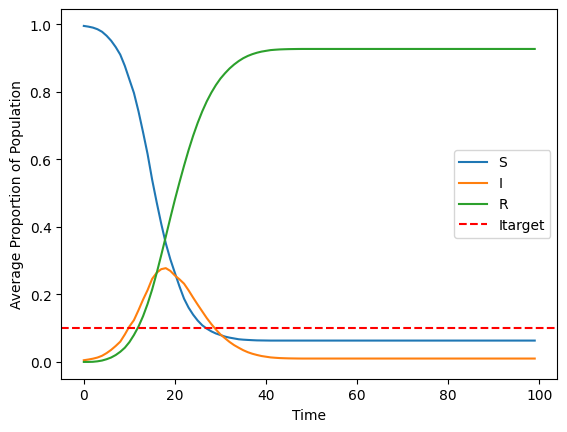

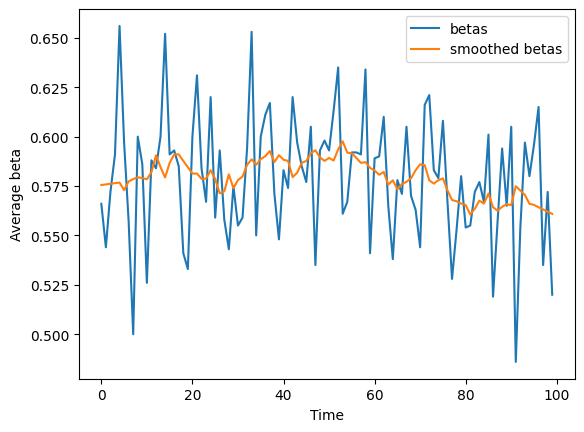

In [ ]:
num_test_iter = 50
num_time_steps = 100
I = produce_avg_graph2(num_test_iter, num_time_steps)